In [1]:
import json
import numpy as np
from get_values import *
import matplotlib.pyplot as plt
import os

##### load multiple run files and nph conversion file

In [113]:
file_path = '/data/user/leidensc/upgrade_installation_ops/freeze_in/'
date_path = '0108'
filenames = []
for file in os.listdir(os.path.join(file_path+date_path)):
    if file.endswith(".json"):
        filenames.append(file)

file_data = {}

for file in filenames:
    with open(os.path.join(os.path.join(file_path,date_path),file), 'r') as f:
        data = json.load(f)
        key = data['file_surfix']
        #key = 'pocam_str87_dev8'
        file_data[key] = data
del data

with open('./freeze_in_adc_nph_conversion.json', 'r') as f:
    conv_data = json.load(f)
    
print(list(file_data.keys()))

['pocam_str88_dev78', 'pocam_str88_dev6', 'pocam_str87_dev8']


##### select specific data file

In [124]:
data = file_data['pocam_str88_dev6']
mmb_id = data['board_IDs']['MMB_ID']
conv = conv_data[mmb_id]

##### environment data

In [125]:
env = data['environment']
templist = []

for elm in env['start'].keys():
    if not 'magnet' in elm:
        if 'temp' in elm:
           templist.append(elm)

templist = {'temp_ib':'IB', 'temp_m_generic':'master AB', 'temp_m_led':'master led', 'temp_m_sipm':'master sipm', 
            'temp_s_generic':'slave AB', 'temp_s_led':'slave led', 'temp_s_sipm':'slave sipm',
            'temp_pressure':'pressure', 'temp_accel':'accelerometer'}

s = env['start']
e = env['end']

p_u = 'mbar'
print('pressure :')
print('\tstart:  {} {}'.format(s['pressure'],p_u))
print('\tend:    {} {}\n'.format(e['pressure'],p_u))
print('accelerometer :')
print('\tstart:  {}'.format(s['accel']))
print('\tend:    {}\n\n'.format(e['accel']))

print('TEMPERATURES:')
for key,item in templist.items():
    print(item+' :')
    print('\tstart:  {} °C'.format(s[key]))
    print('\tend:    {} °C\n'.format(e[key]))





pressure :
	start:  507.592 mbar
	end:    508.009 mbar

accelerometer :
	start:  [-5.24384, -8.40771, -0.0244783]
	end:    [-5.24384, -8.40801, -0.0245166]


TEMPERATURES:
IB :
	start:  4.187500 °C
	end:    5.125000 °C

master AB :
	start:  -0.125000 °C
	end:    0.062500 °C

master led :
	start:  -0.187500 °C
	end:    0.062500 °C

master sipm :
	start:  0.250000 °C
	end:    0.625000 °C

slave AB :
	start:  -1.000000 °C
	end:    -0.750000 °C

slave led :
	start:  -0.875000 °C
	end:    -0.625000 °C

slave sipm :
	start:  -0.812500 °C
	end:    -0.375000 °C

pressure :
	start:  10.63 °C
	end:    10.74 °C

accelerometer :
	start:  14.6133 °C
	end:    14.5028 °C



##### load darkrate sample for both ADC channels and both hemsipheres

In [126]:
dark_m = extract_dark(data['darkcount'],'m')
dark_s = extract_dark(data['darkcount'],'s')

dark_m_adcA = np.array([i['sum'] for i in dark_m['adcA']]).mean()
dark_s_adcA = np.array([i['sum'] for i in dark_s['adcA']]).mean()
dark_m_adcB = np.array([i['sum'] for i in dark_m['adcB']]).mean()
dark_s_adcB = np.array([i['sum'] for i in dark_s['adcB']]).mean()

In [127]:
def graph(emitter, width):
    data_set = data[emitter]
    fig, ax = plt.subplots(figsize = (18,4), ncols = 3, nrows =1)

    if width == 'short':
        if 'KAPU' in emitter:
            mode = 'fast'
        else:
            mode = '1-20'
    elif width == 'long':
        if 'KAPU' in emitter:
            mode = 'default'
        else:
            mode = '2-20'

    m_A = conv['master'][emitter]['fit_para_adcA']
    s_A = conv['slave'][emitter]['fit_para_adcA']
    m_B = conv['master'][emitter]['fit_para_adcB']
    s_B = conv['slave'][emitter]['fit_para_adcB']
    

    mode_data = data_set[mode]
    pwm_m = mode_data['pwm_values_master'][0]
    pwm_s = mode_data['pwm_values_slave'][0]

    #print(f'pwm master:   {pwm_m}')
    #print(f'pwm slave:    {pwm_s}')
    
    
    for ph in mode_data['intensities']:
        ph_data = mode_data[str(ph)]
        time0 = ph_data['master']['CalTrig_times'][0]
        
        for side in ph_data.keys():
            side_data = ph_data[side]

            times = (np.array(side_data['CalTrig_times'])-time0)/(8*60e6)

            if side == 'master':
                m_data = extract(side_data,side='m')
                
                ax[0].scatter(times, m_A[0]*(m_data['adcA']['sum']-dark_m_adcA)+m_A[1], color = 'purple')
                ax[0].scatter(times, m_B[0]*(m_data['adcB']['sum']-dark_m_adcB)+m_B[1], color = 'blue')
                ax[0].set_title(f'master  {pwm_m}', fontsize = 15)
            
            elif side == 'slave':
                s_data = extract(side_data,side='s')
                ax[1].scatter(times, s_A[0]*(s_data['adcA']['sum']-dark_s_adcA)+s_A[1], color = 'pink')
                ax[1].scatter(times, s_B[0]*(s_data['adcB']['sum']-dark_s_adcB)+s_B[1], color = 'lightblue')
                ax[1].set_title(f'slave  {pwm_s}', fontsize = 15)

            else:
                m_data = extract(side_data,side='m')
                s_data = extract(side_data,side='s')
                ax[2].scatter(times, m_A[0]*(m_data['adcA']['sum']-dark_m_adcA)+m_A[1], color = 'purple', label = 'master/ adcA')
                ax[2].scatter(times, s_A[0]*(s_data['adcA']['sum']-dark_s_adcA)+s_A[1], color = 'pink', label = 'slave/    adcA')
                ax[2].scatter(times, m_B[0]*(m_data['adcB']['sum']-dark_m_adcB)+m_B[1], color = 'blue', label = 'master/ adcB')
                ax[2].scatter(times, s_B[0]*(s_data['adcB']['sum']-dark_s_adcB)+s_B[1], color = 'lightblue', label = 'slave/    adcB')
                ax[2].set_title('both', fontsize = 15)
    
    for axis in ax:
        axis.set_xlabel('time [s]')
        axis.set_ylabel('Number of photons')
    fig.legend(loc='upper right')#,bbox_to_anchor=(1.2, 0.89))
    plt.show()
    

#### plot the emitter and pulsewidth you want

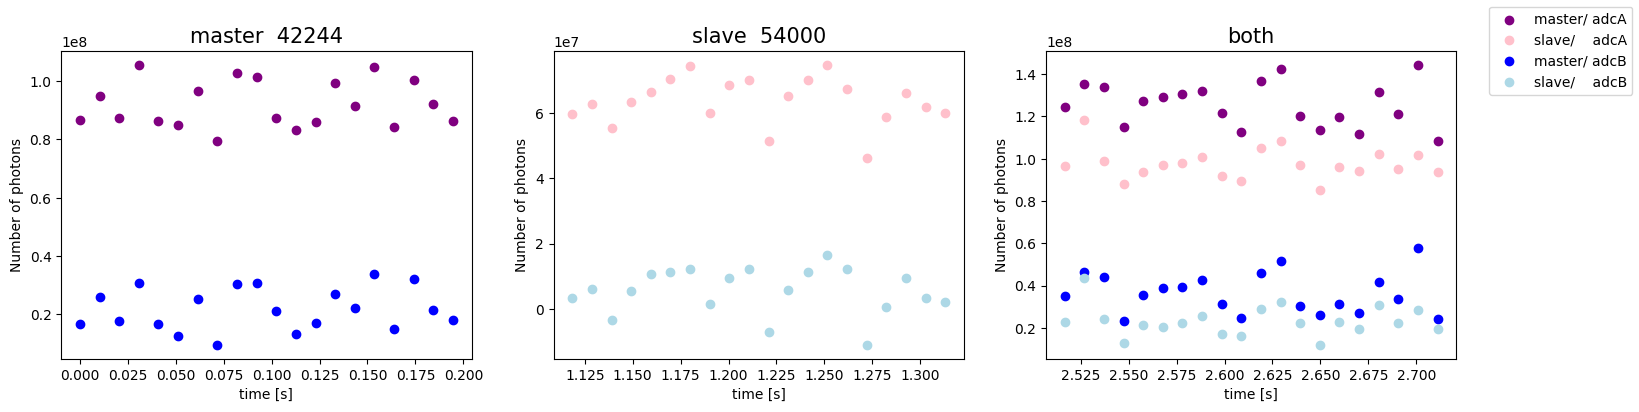

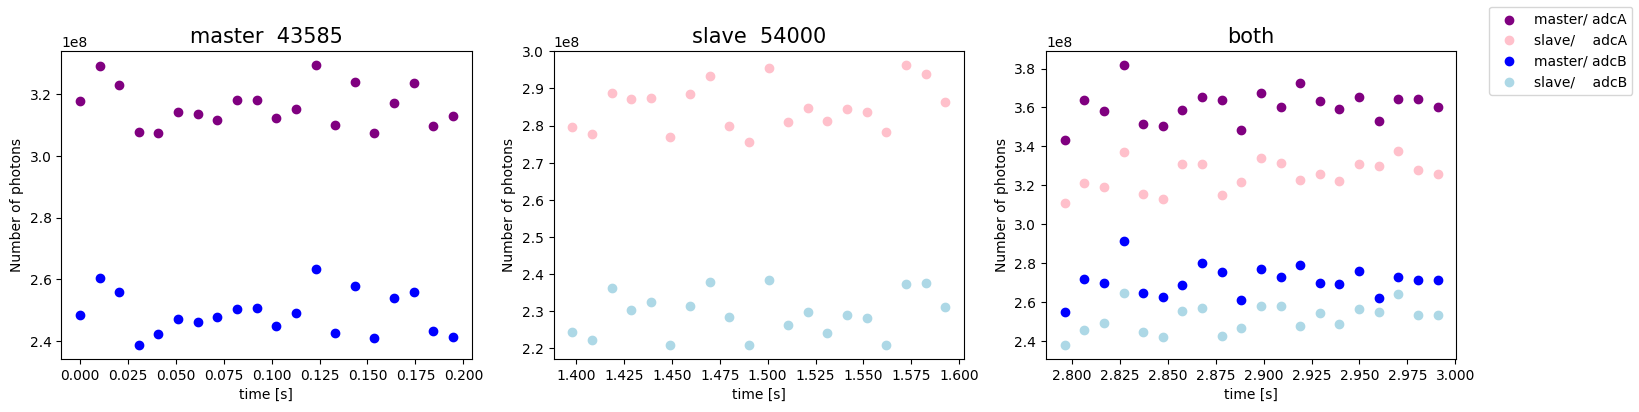

In [128]:
graph('KAPU405', 'short')
graph('KAPU405', 'long')

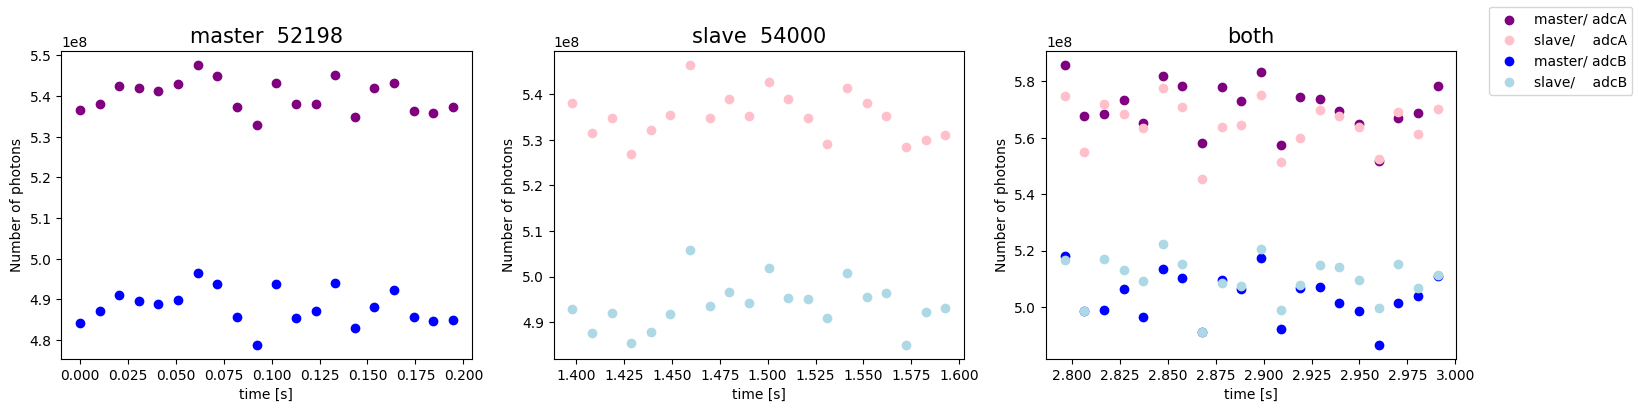

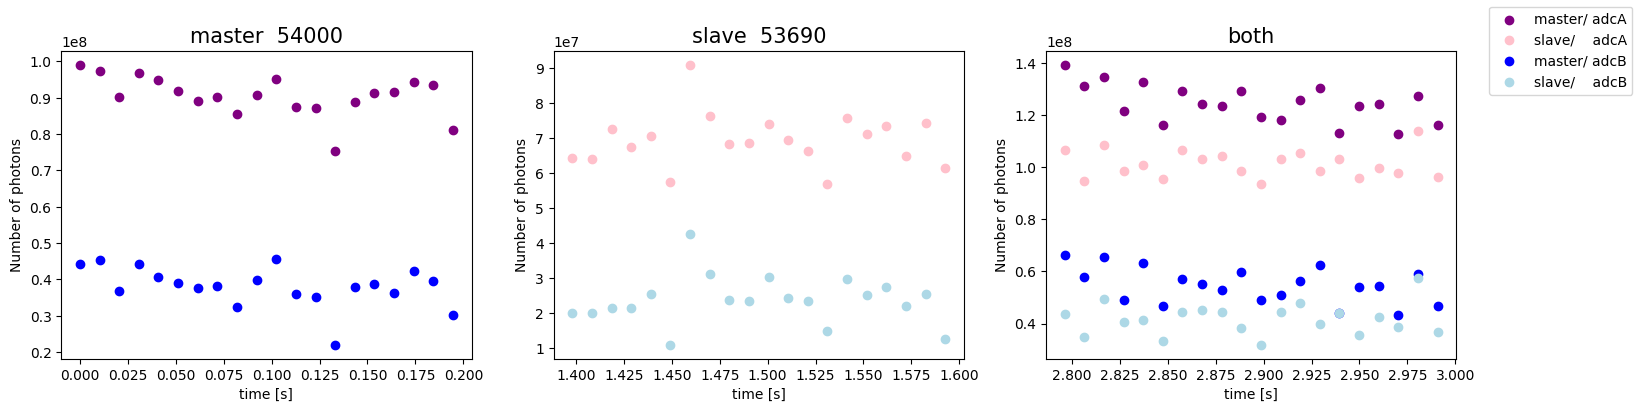

In [129]:
graph('KAPU465','short')
graph('KAPU465','long')

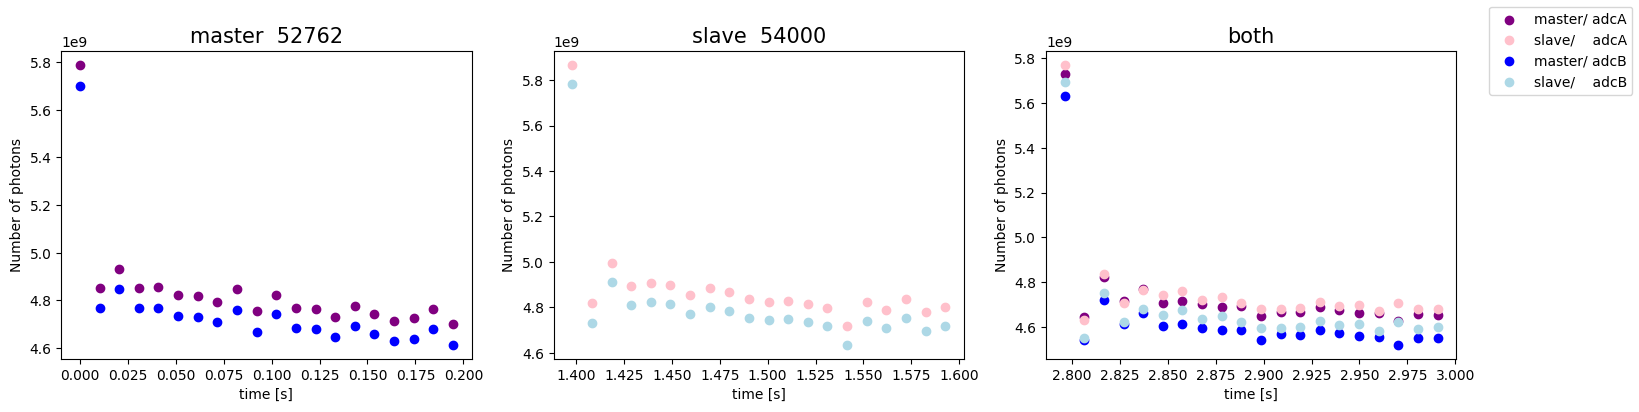

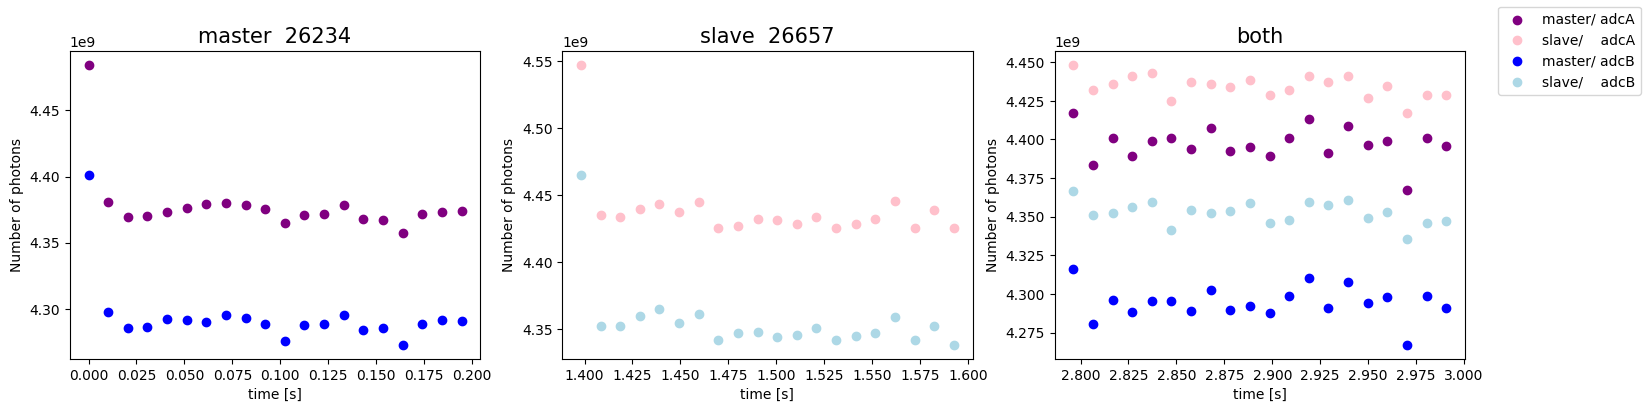

In [130]:
graph('LMG405','short')
graph('LMG405','long')

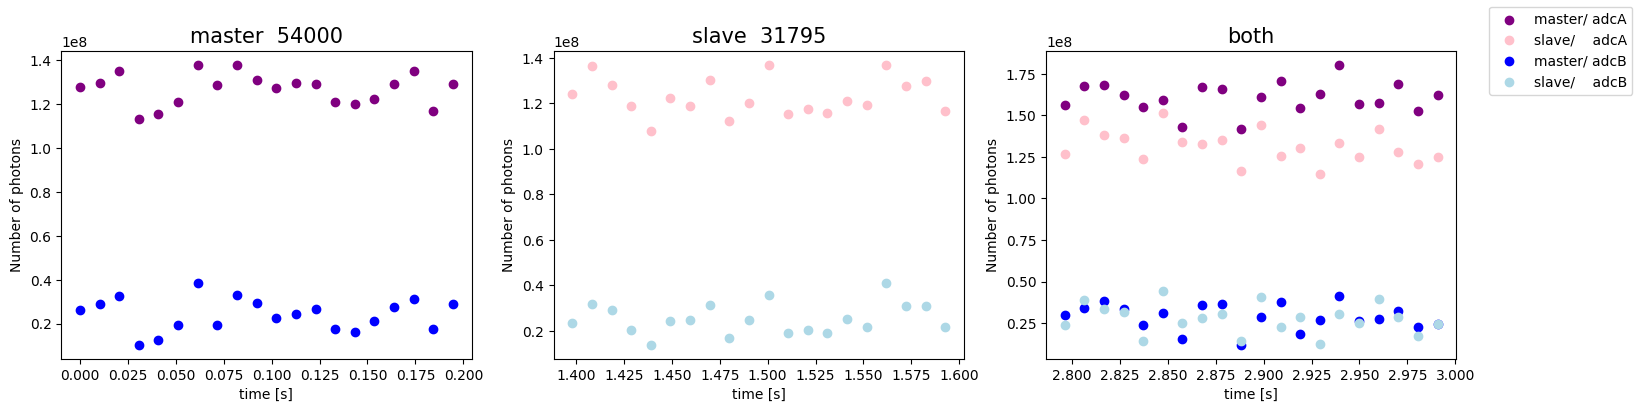

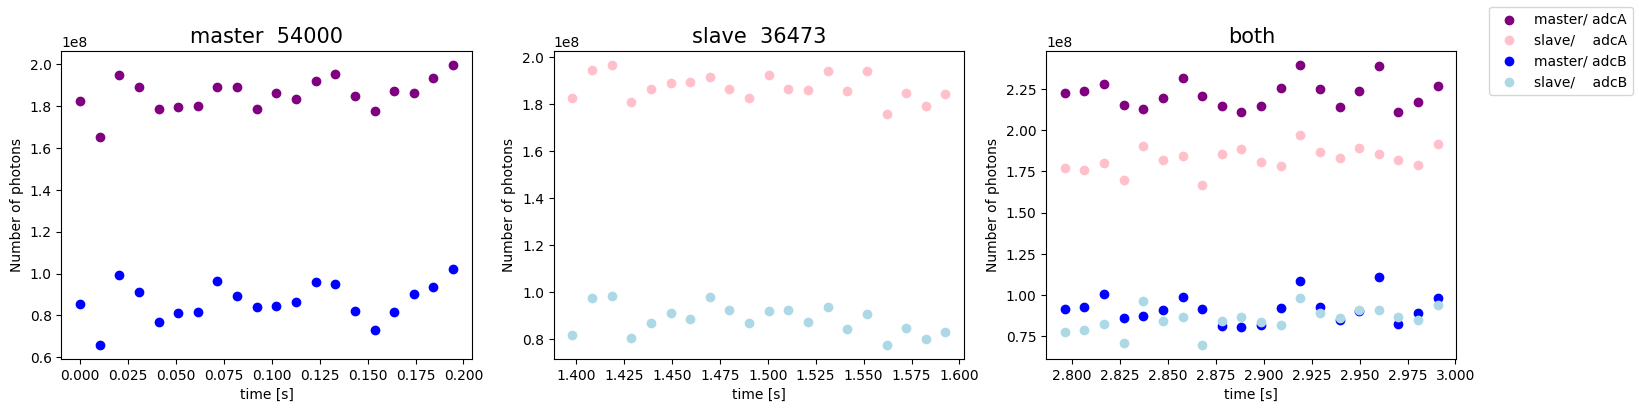

In [131]:
graph('LMG365','short')
graph('LMG365','long')

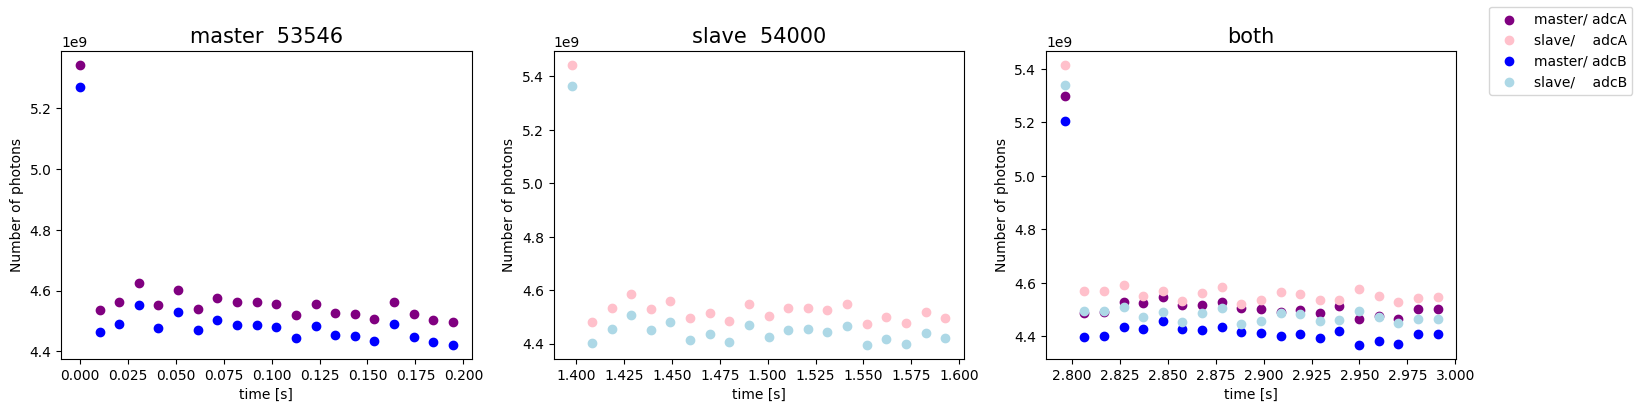

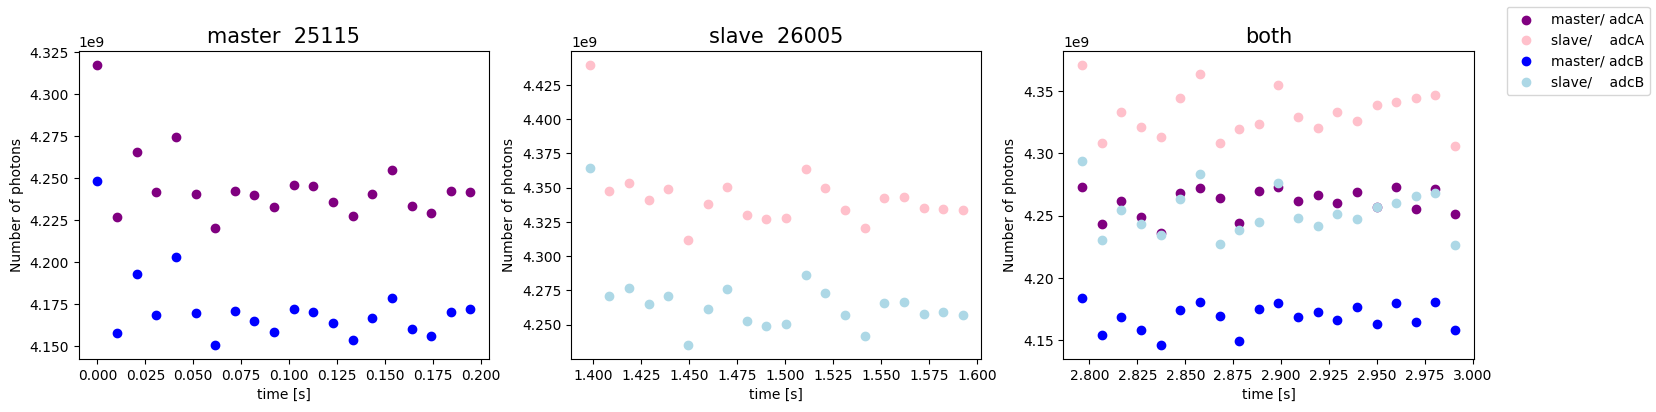

In [132]:
graph('LMG450','short')
graph('LMG450','long')

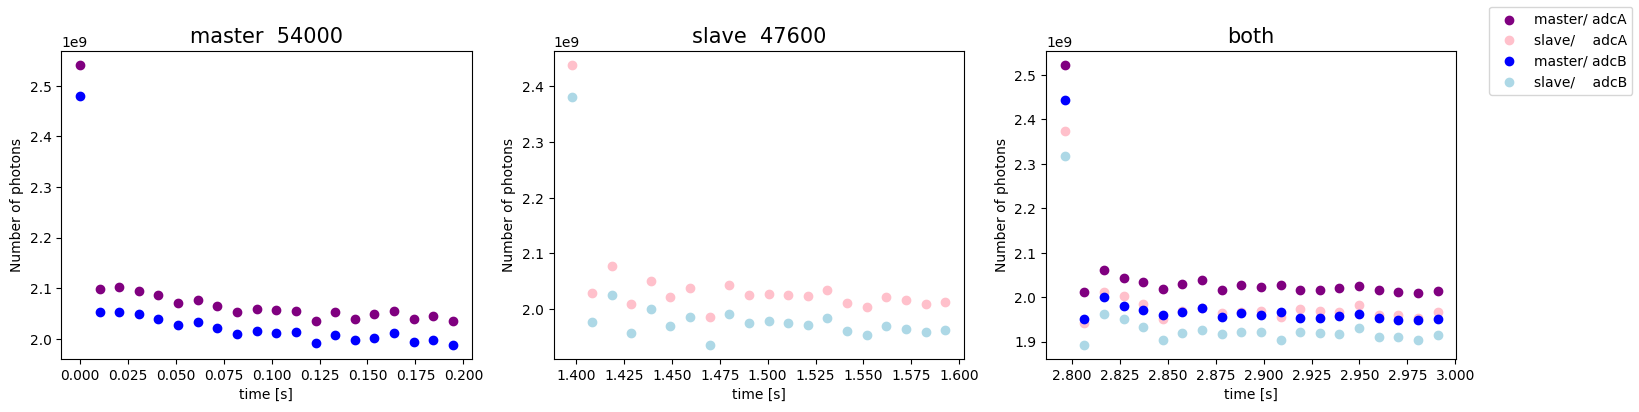

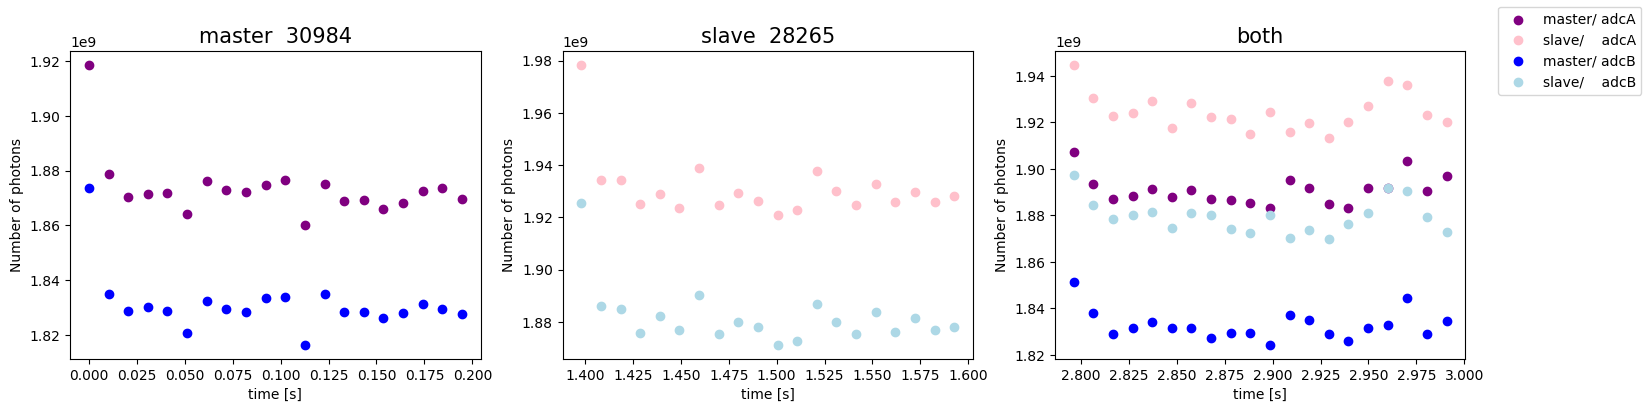

In [133]:
graph('LMG520','short')
graph('LMG520','long')

##### probably unimportant: Trigger times to get time windows for actual flasher windows in DOMs

In [17]:
dark_trigs = np.array(data['darkcount']['CalTrig_times'])/(8*60e6)

#print(dark_trigs-dark_trigs[0])
#print(len(data['darkcount']['CalTrig_times']))

mode_data0 = data['KAPU405']['fast']
ph_data0 = mode_data0[str(mode_data0['intensities'][0])]
time0 = (np.array(ph_data0['master']['CalTrig_times'])/(8*60e6))[0]
print(time0)

trig_dct = {}

for emitter in ['KAPU405', 'KAPU465', 'LMG405', 'LMG365','LMG450', 'LMG520']:
    trig_dct[emitter] = {}
    for width in ['short','long']:
        data_set = data[emitter]
        # fig, ax = plt.subplots(figsize = (18,4), ncols = 3, nrows =1)

        if width == 'short':
            if 'KAPU' in emitter:
                mode = 'fast'
            else:
                mode = '1-20'
        elif width == 'long':
            if 'KAPU' in emitter:
                mode = 'default'
            else:
                mode = '2-20'

        mode_data = data_set[mode]
        for ph in mode_data['intensities']:
            ph_data = mode_data[str(ph)]
            #time0 = ph_data['master']['CalTrig_times'][0]
            
            side_data = ph_data['both']

            times = (np.array(side_data['CalTrig_times']))/(8*60e6)

            trig_dct[emitter][width] = times -time0

            
        


388068.1908907333


In [62]:
trig_dct

{'KAPU405': {'short': array([2.5165824, 2.5268224, 2.5370624, 2.5473024, 2.5575424, 2.5677824,
         2.5780224, 2.5882624, 2.5985024, 2.6087424, 2.6189824, 2.6292224,
         2.6394624, 2.6497024, 2.6599424, 2.6701824, 2.6804224, 2.6906624,
         2.7009024, 2.7111424]),
  'long': array([8.66822827, 8.67846827, 8.68870827, 8.69894827, 8.70918827,
         8.71942827, 8.72966827, 8.73990827, 8.75014827, 8.76038827,
         8.77062827, 8.78086827, 8.79110827, 8.80134827, 8.81158827,
         8.82182827, 8.83206827, 8.84230827, 8.85254827, 8.86278827])},
 'KAPU465': {'short': array([15.9383552, 15.9485952, 15.9588352, 15.9690752, 15.9793152,
         15.9895552, 15.9997952, 16.0100352, 16.0202752, 16.0305152,
         16.0407552, 16.0509952, 16.0612352, 16.0714752, 16.0817152,
         16.0919552, 16.1021952, 16.1124352, 16.1226752, 16.1329152]),
  'long': array([22.09000107, 22.10024107, 22.11048107, 22.12072107, 22.13096107,
         22.14120107, 22.15144107, 22.16168107, 22.1719